# Demo of SF error analysis
**Semi-empirical approach to computing second-order statistics of gapped series**

Structure functions = statistical moments of increments:
$$D_p(\tau)=\langle | x(t+\tau)-x(t))^p | \rangle$$

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.sf_funcs as sf
import pickle

plt.rcParams.update({"font.size": 12})

# Set seed for reproducibility
np.random.seed(42)

## Load in the data
A magnetic field time series from PSP, already processed into Pandas DataFrame format

In [3]:
df_raw_full = pd.read_pickle("data/processed/psp/psp_fld_l2_mag_rtn_201811.pkl")
df_raw = df_raw_full["B_R"]
df_raw.head()

Time
2018-11-02 00:01:09.195182976   -11.061315
2018-11-02 00:01:09.208836480   -10.854164
2018-11-02 00:01:09.222489856   -11.197883
2018-11-02 00:01:09.236143104   -11.008248
2018-11-02 00:01:09.249796352   -11.188342
Name: B_R, dtype: float64

Optionally, check the data for missing data and its frequency, get summary stats

In [4]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}".format(np.std(x)))

### 0PTIONAL CODE END ###

510 missing points
Length of interval: 7522952
Duration of interval: 0 days 17:59:59.987519872
Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)
Mean = nan
Standard deviation = nan


## Standardise each interval 
to contain 8 correlation times `tc`. Start with *approximately* 15 correlation times across 75,000 points, then calculate correlation time and use this value to down-sample to 8 correlation times across 10,000 points.

In [5]:
tc_approx = 500  # s
tc_approx_n = 15
cadence_approx = 0.1  # s

tc_n = 8  # Number of correlation times we want...
interval_length = 4000  # ...across this many points
good_inputs_list = []

df = df_raw.resample(str(cadence_approx) + "S").mean()
interval_length_approx = int(tc_approx * tc_approx_n / cadence_approx)

In [6]:
# Original freq is 0.007s. Resampling to less rapid but still sufficiently high cadence, then splitting into chunks with ~15 correlation times

tc_approx = 500  # s
tc_approx_n = 15
cadence_approx = 0.1  # s

tc_n = 8  # Number of correlation times we want...
interval_length = 4000  # ...across this many points
good_inputs_list = []

df = df_raw.resample(str(cadence_approx) + "S").mean()
interval_length_approx = int(tc_approx * tc_approx_n / cadence_approx)

# We have approximately 15 correlation times in 10,000 points. Let's now be more precise, and calculate the correlation time from each chunk

# Split df into subsets
interval_list_approx = [
    df[i : i + interval_length_approx]
    for i in range(0, len(df) - interval_length_approx + 1, int(interval_length_approx))
]

del df  # free up memory

tc_list = []

for interval_approx in interval_list_approx:
    time_lags_lr, r_vec_lr = utils.compute_nd_acf(
        [interval_approx],
        nlags=10000,
        plot=False,
    )

    tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

    if tc == -1:
        tc = 500
        new_cadence = tc_n * tc / interval_length
        print(
            f"tce not found for this chunk, setting to 500s (default) -> cadence = {new_cadence}s"
        )

    else:
        new_cadence = tc_n * tc / interval_length
        print(
            f"tce calculated to be {np.round(tc,2)}s -> cadence = {np.round(new_cadence,2)}s (for {tc_n}tce across {interval_length} points)"
        )

    tc_list.append(tc)

    interval_approx_resampled = interval_approx.resample(
        str(new_cadence) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        int_norm = utils.normalize(interval)
        good_inputs_list.append(int_norm)

print(
    "\nNumber of standardised intervals: "
    + str(len(good_inputs_list))
    + "\n(may be more than one per original chunk for small cadences)"
)

tce calculated to be 472.44s -> cadence = 0.94s (for 8tce across 4000 points)
tce calculated to be 519.81s -> cadence = 1.04s (for 8tce across 4000 points)
tce calculated to be 724.28s -> cadence = 1.45s (for 8tce across 4000 points)
tce calculated to be 612.58s -> cadence = 1.23s (for 8tce across 4000 points)
tce not found for this chunk, setting to 500s (default) -> cadence = 1.0s
tce calculated to be 181.96s -> cadence = 0.36s (for 8tce across 4000 points)
tce calculated to be 860.62s -> cadence = 1.72s (for 8tce across 4000 points)
tce not found for this chunk, setting to 500s (default) -> cadence = 1.0s

Number of standardised intervals: 12
(may be more than one per original chunk for small cadences)


In [7]:
interval_list_approx[-1].index[-1]

Timestamp('2018-11-02 16:41:09', freq='100L')

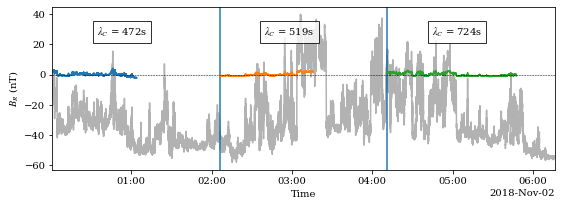

In [8]:
plt.rcParams.update({"font.size": 16})
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(9, 3))
[plt.plot(interval, alpha=0.3, c="black") for interval in interval_list_approx[:3]]
[plt.axvline(interval.index[-1]) for interval in interval_list_approx[:2]]
[plt.plot(interval) for interval in good_inputs_list[:3]]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
for index, tc in enumerate(tc_list[:3]):
    plt.text(
        x=interval_list_approx[index].index[0] + pd.Timedelta(seconds=2000),
        y=26,
        s=f"$\lambda_C$ = {int(tc)}s",
        bbox=dict(facecolor="white", alpha=0.8),
    )
# plt.suptitle(
#     f"Standardised solar wind time series: {tc_n}$\lambda_C$ across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$)",
#     fontsize=15,
# )
# # Add subtitle
# plt.title("Started with intervals $\sim$ 15$\lambda_C$ before refining", fontsize=12)

ax.set_xlim(interval_list_approx[0].index[0], interval_list_approx[2].index[-1])
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel("$B_R$ (nT)")
# Tidy the timestamp x-axis
# plt.xticks(rotation=20)

plt.savefig("plots/int_standardised_demo.png")

In [9]:
def get_lag_vals_list(df):
    lag_vals_wide = pd.DataFrame(df["sq_diffs"].tolist(), index=df.index)
    lag_vals_wide.reset_index(inplace=True)  # Make the index a column
    lag_vals_wide.rename(columns={"index": "lag"}, inplace=True)
    lag_vals = pd.melt(
        lag_vals_wide, id_vars=["lag"], var_name="index", value_name="sq_diffs"
    )
    return lag_vals

c:\Users\spann\Documents\Research\Code repos\time_series_analysis\Kea\Kea\utils\funcs.py:142: RuntimeWarning: divide by zero encountered in reciprocal
  pl = (xx/bb)**(-a1) * (0.5 * (1. + (xx/bb)**(1./delta)))**((a1 - a2)*delta)


[[<matplotlib.lines.Line2D at 0x26f6418ada0>],

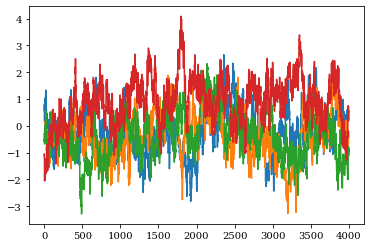

In [10]:
# SIMULATE FBM FIELD FOR PLOTTING VARIOGRAM CLOUDS, AS WELL AS PDP DATA

from Kea.Kea.simulator import fbm as fbm
import random as random

N = 4000
D = 1
L = N

# 1. Specifying Hurst parameter (using fbm package)

# for H in [0.25, 0.5, 0.75]:
#     fbm_generator = FBM(n=N, hurst=H, length=L, method="daviesharte")
#     process = fbm_generator.fbm()
#     plt.plot(process, label=f"H = {H}")
# plt.title("fBm with different Hurst parameters")
# plt.legend()
# plt.show()

# 2. Specifying power-law/s (using Mark's Kea package)

dk = 2.0 * np.pi / L
BREAK = 100.0 * dk

random.seed(42)
# Repeat the below 4 times
x_periodic = fbm.create_fbm(
    grid_dims=[4 * N for _ in range(D)],
    phys_dims=[L for _ in range(D)],
    alphas=(-1.0, -5.0 / 3.0),
    gfunc="smooth_pow",
    func_kwargs={"breaks": (BREAK,), "delta": 0.25},
)

# x = x_periodic[:N]  # removing periodicities inherent in complete field
fbm_fields = [(x_periodic[i * N : (i + 1) * N]) for i in range(4)]
[plt.plot(fbm_fields[i]) for i in range(len(fbm_fields))]

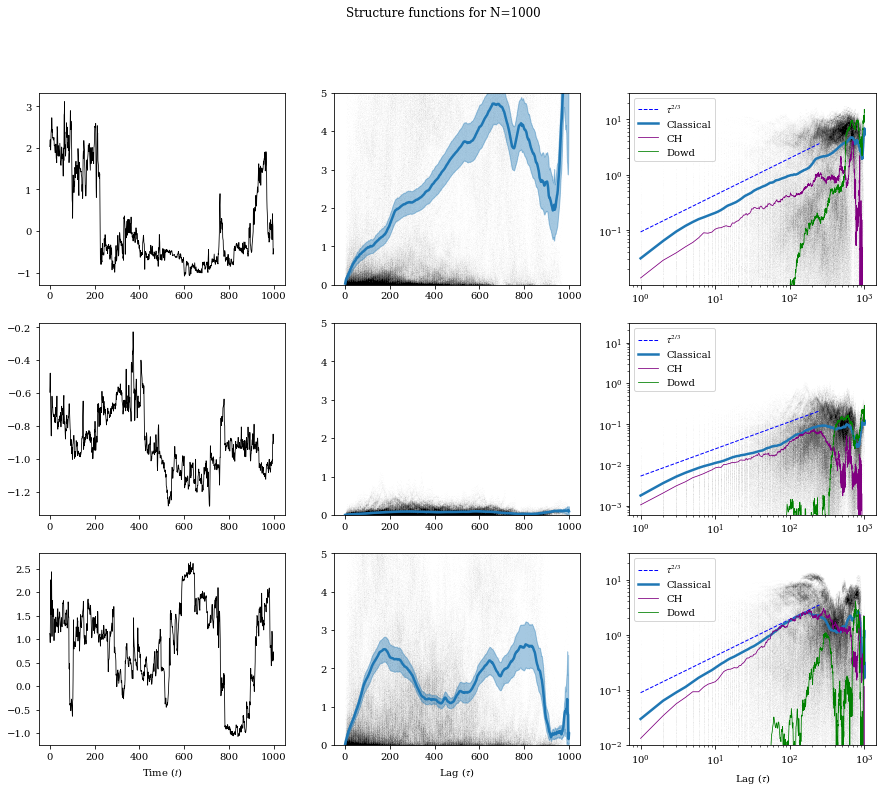

In [11]:
# WHEN CHANGING SAMPLE SIZE: change max lag and transparency too
# WHEN GOING TO -INTS FOR PSP: change ylim from 15 to 5

dt = 1
n = 1000  # sample size
n_ints = 3
fig, ax = plt.subplots(n_ints, 3, figsize=(15, 4 * n_ints))
for i, interval in enumerate(
    good_inputs_list[:n_ints]
):  # fbm_fields or good_inputs_list
    x = interval[:n]

    # Compute the structure function
    lags = np.arange(1, len(x))  # prev 0.25
    lag_times = lags * dt
    powers = [0.5, 2]

    good_output = sf.compute_sf(pd.DataFrame(x), lags, powers, retain_increments=True)

    good_output["ch_numerator"] = good_output["0.5_mean"] ** 4
    good_output["ch"] = good_output["ch_numerator"] / (
        0.457 + (0.494 / good_output["n"]) + (0.045 / good_output["n"] ** 2)
    )
    # Final part of original correction is so small as to be neglibile, hence why often left out
    # Down-weights outliers - recommended to use both
    good_output["dowd"] = (good_output["mapd"] ** 2) * 2.198

    lag_vals = get_lag_vals_list(good_output)

    ax[i, 0].plot(np.arange(0, len(x)), x, c="black", lw=0.8)

    # ax.scatter(lag_vals["lag"], lag_vals["sq_diffs"], alpha=0.005, s=0.5, c="black")
    # Plot a 2/3 power law, with the first point at the minimum of the classical structure function
    ax[i, 2].plot(
        lag_times[: int(len(lag_times) / 4)],
        3
        * good_output["classical"][1]
        * lag_times[: int(len(lag_times) / 4)] ** (2 / 3),
        label=r"$\tau^{2/3}$",
        lw=1,
        c="blue",
        ls="--",
    )
    ax[i, 1].plot(
        lag_times, good_output["classical"], label="Classical", lw=2.5, c="C0"
    )
    ax[i, 2].plot(
        lag_times, good_output["classical"], label="Classical", lw=2.5, c="C0"
    )
    ax[i, 2].plot(lag_times, good_output["ch"], label="CH", lw=0.8, c="purple")
    ax[i, 2].plot(lag_times, good_output["dowd"], label="Dowd", lw=0.8, c="green")

    # lag_vals = sf.get_lag_vals_list(good_output)
    ax[i, 1].scatter(
        lag_vals["lag"] * dt,
        lag_vals["sq_diffs"],
        # 0.3 and 0.00001 for 4000 points, 1 for 1000
        alpha=1,
        s=0.00001,
        c="black",
    )

    x = 3  # Number of standard errors to plot
    ax[i, 1].fill_between(
        good_output["lag"],
        np.maximum(
            good_output["classical"] - x * good_output["classical_se"],
            0,
        ),
        good_output["classical"] + x * good_output["classical_se"],
        color="C0",
        alpha=0.4,
        label=f"$\pm$ {x} SE",
    )

    ax[i, 2].scatter(
        lag_vals["lag"] * dt,
        lag_vals["sq_diffs"],
        alpha=1,
        s=0.00001,
        c="black",
    )

    # plt.ylim(0, 300)
    ax[n_ints - 1, 0].set_xlabel(r"Time ($t$)")
    ax[n_ints - 1, 1].set_xlabel(r"Lag ($\tau$)")
    ax[n_ints - 1, 2].set_xlabel(r"Lag ($\tau$)")
    ax[i, 2].semilogx()
    ax[i, 2].semilogy()
    ax[i, 1].set_ylim(0, 5)
    ax[i, 2].set_ylim(
        good_output["classical"].min() / 3,
        30,
        # good_output["classical"].max() * 10
    )  # log-space: *5
    ax[i, 2].legend(loc="upper left")

fig.suptitle(f"Structure functions for N={n}")
# plt.savefig(f"fbm_variogram_clouds_n_{n}.png")
plt.show()

In [ ]:
import importlib

importlib.reload(sf)

<module 'src.sf_funcs' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\time_series_analysis\\src\\sf_funcs.py'>

In [13]:
x_full = good_inputs_list[0]

In [ ]:
test = sf.compute_sf(pd.DataFrame(x_full), lags, powers, retain_increments=True)

(array([  19.,   86.,  135.,  432., 1127., 1230.,  617.,  171.,   60.,
          23.]),
 array([-3.59931323, -2.91313126, -2.22694928, -1.54076731, -0.85458534,
        -0.16840337,  0.51777861,  1.20396058,  1.89014255,  2.57632452,
         3.26250649]),
 <BarContainer object of 10 artists>)

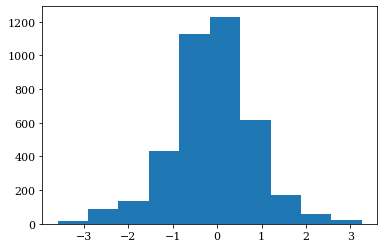

In [ ]:
plt.hist(test["1_diffs"][100])

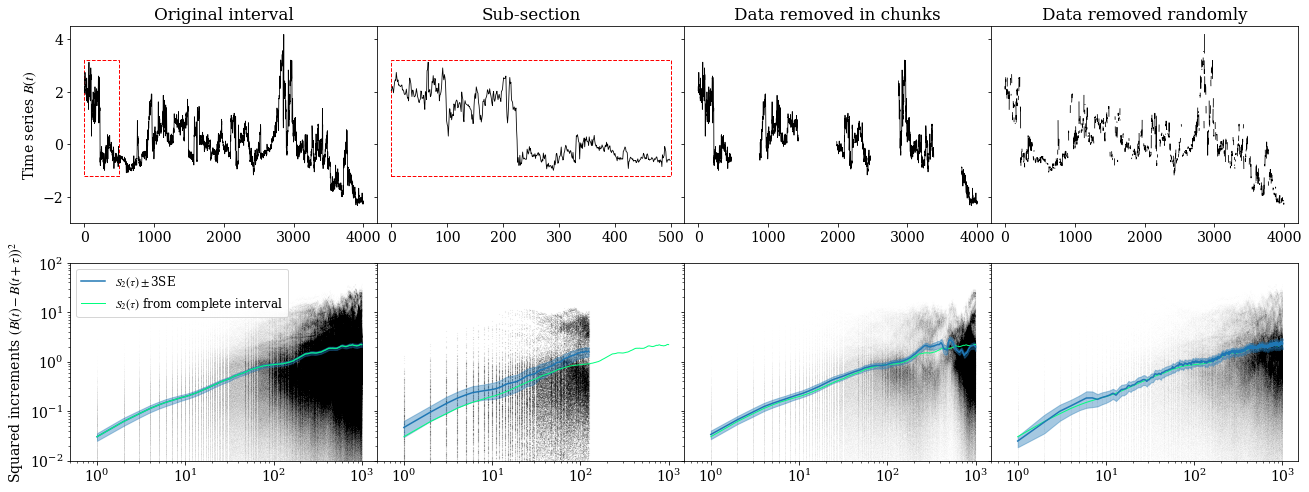

In [45]:
# WHEN CHANGING SAMPLE SIZE: change max lag and transparency too
# WHEN GOING TO -INTS FOR PSP: change ylim from 15 to 5
from matplotlib.patches import Rectangle

dt = 1
# n = 1000  # sample size
n_ints = 3
fig, ax = plt.subplots(
    2, 4, figsize=(22, 8), gridspec_kw={"hspace": 0.2, "wspace": 0}, sharey="row"
)
# Adjust spacing between subplots

x_full = good_inputs_list[0]
x_ns = x_full[0:500]
random.seed(42)
x_missing_chunks = ts.remove_data(x_full.values, 0.5, 5)[0]
x_missing_uniform = ts.remove_data(x_full.values, 0.5)[0]

alpha = [0.3, 1, 0.5, 0.5]
size = [0.00001, 0.0005, 0.00001, 0.00001]

for i, interval in enumerate([x_full, x_ns, x_missing_chunks, x_missing_uniform]):
    # interval = x_full
    # i = 0
    # x_full  # , x_ns, x_missing, x_missing_uniform
    # ):  # fbm_fields or good_inputs_list

    x = interval
    ax[0, i].plot(np.arange(0, len(x)), x, c="black", lw=0.8)

    # Compute the structure function
    lags = np.arange(1, int(0.25 * len(x)))  # prev 0.25
    lag_times = lags * dt
    powers = [0.5, 1, 2]

    good_output = sf.compute_sf(pd.DataFrame(x), lags, powers, retain_increments=True)

    lag_vals_1 = sf.get_lag_vals_list(good_output, "1_diffs")
    ax[1, i].scatter(
        lag_vals_1["lag"] * dt,
        lag_vals_1["1_diffs"],
        alpha=alpha[i],
        s=size[i],
        c="black",
    )

    lag_vals_sq = sf.get_lag_vals_list(good_output, "sq_diffs")
    ax[1, i].scatter(
        lag_vals_sq["lag"] * dt,
        lag_vals_sq["sq_diffs"],
        alpha=alpha[i],
        s=size[i],
        c="black",
    )

    ax[1, i].plot(
        lag_times, good_output["classical"], label="$S_2(\\tau)\pm$3SE", lw=1.5, c="C0"
    )
    if i == 0:
        for j in range(4):
            ax[1, j].plot(
                lag_times,
                good_output["classical"],
                label="$S_2(\\tau)$ from complete interval",
                lw=1,
                c="springgreen",
            )

    x = 3  # Number of standard errors to plot
    ax[1, i].fill_between(
        good_output["lag"],
        np.maximum(
            good_output["classical"] - x * good_output["classical_se"],
            0,
        ),
        good_output["classical"] + x * good_output["classical_se"],
        color="C0",
        alpha=0.4,
        # label=f"$\pm$ {x} SE",
    )
    ax[0, i].set_ylim(-3, 4.5)

    ax[1, i].semilogx()
    ax[1, i].semilogy()
    ax[1, i].set_xlim(5e-1, 1.5e3)
    ax[1, i].set_ylim(1e-2, 1e2)

# Add rectangle around subset
rect1 = Rectangle(
    (0, -1.2), 500, 4.4, linewidth=1, edgecolor="r", facecolor="none", linestyle="--"
)
rect2 = Rectangle(
    (0, -1.2), 500, 4.4, linewidth=1, edgecolor="r", facecolor="none", linestyle="--"
)
ax[0, 0].add_patch(rect1)
ax[0, 1].add_patch(rect2)
ax[0, 0].set_title("Original interval")
ax[0, 1].set_title("Sub-section")
ax[0, 2].set_title("Data removed in chunks")
ax[0, 3].set_title("Data removed randomly")

ax[0, 0].set_ylabel("Time series $B(t)$")
ax[1, 0].set_ylabel("Squared increments $(B(t) - B(t+\\tau))^2$")
ax[1, 0].legend(loc="upper left", fontsize=12)

# Increase matplotlib font size
plt.rcParams.update({"font.size": 14})

plt.show()

## FBM VERSION

In [46]:
fbm_fields[0]

array([ 0.57560866,  0.79991009,  0.36981648, ..., -1.11543663,
       -0.93797234, -0.84003155])

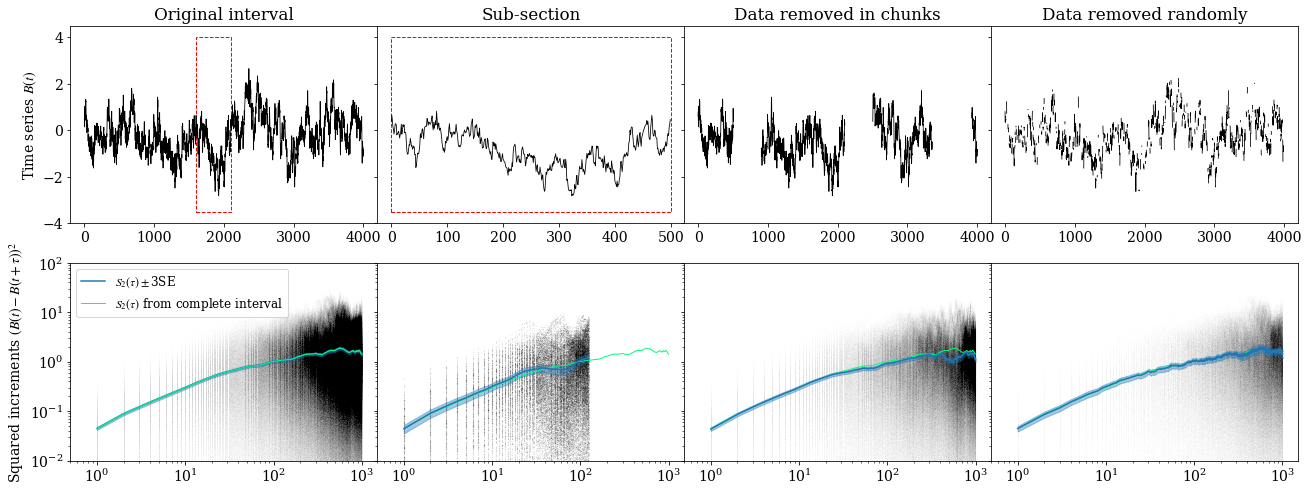

In [47]:
# WHEN CHANGING SAMPLE SIZE: change max lag and transparency too
# WHEN GOING TO -INTS FOR PSP: change ylim from 15 to 5

dt = 1
# n = 1000  # sample size
n_ints = 3
fig, ax = plt.subplots(
    2, 4, figsize=(22, 8), gridspec_kw={"hspace": 0.2, "wspace": 0}, sharey="row"
)  # Adjust spacing between subplots
x_full = pd.DataFrame(fbm_fields[0])
subset_start = 1600
subset_end = 2100
x_ns = x_full[subset_start:subset_end]
random.seed(42)
x_missing_chunks = ts.remove_data(x_full.values, 0.5, 5)[0]
x_missing_uniform = ts.remove_data(x_full.values, 0.5)[0]

alpha = [0.3, 1, 0.5, 0.5]
size = [0.00001, 0.0005, 0.00001, 0.00001]

for i, interval in enumerate([x_full, x_ns, x_missing_chunks, x_missing_uniform]):
    # interval = x_full
    # i = 0
    # x_full  # , x_ns, x_missing, x_missing_uniform
    # ):  # fbm_fields or good_inputs_list

    x = interval
    ax[0, i].plot(np.arange(0, len(x)), x, c="black", lw=0.8)

    # Compute the structure function
    lags = np.arange(1, int(0.25 * len(x)))  # prev 0.25
    lag_times = lags * dt
    powers = [0.5, 1, 2]

    good_output = sf.compute_sf(pd.DataFrame(x), lags, powers, retain_increments=True)

    lag_vals_sq = sf.get_lag_vals_list(good_output, "sq_diffs")
    ax[1, i].scatter(
        lag_vals_sq["lag"] * dt,
        lag_vals_sq["sq_diffs"],
        alpha=alpha[i],
        s=size[i],
        c="black",
    )

    ax[1, i].plot(
        lag_times, good_output["classical"], label="$S_2(\\tau)\pm$3SE", lw=1.5, c="C0"
    )
    if i == 0:
        for j in range(4):
            ax[1, j].plot(
                lag_times,
                good_output["classical"],
                label="$S_2(\\tau)$ from complete interval",
                lw=1,
                c="springgreen",
            )

    x = 3  # Number of standard errors to plot
    ax[1, i].fill_between(
        good_output["lag"],
        np.maximum(
            good_output["classical"] - x * good_output["classical_se"],
            0,
        ),
        good_output["classical"] + x * good_output["classical_se"],
        color="C0",
        alpha=0.4,
        # label=f"$\pm$ {x} SE",
    )
    ax[0, i].set_ylim(-4, 4.5)

    ax[1, i].semilogx()
    ax[1, i].semilogy()
    ax[1, i].set_xlim(5e-1, 1.5e3)
    ax[1, i].set_ylim(1e-2, 1e2)

# Add rectangle around subset
rect1 = Rectangle(
    (subset_start, -3.5),
    subset_end - subset_start,
    7.5,
    linewidth=1,
    edgecolor="r",
    facecolor="none",
    linestyle="--",
)
rect2 = Rectangle(
    (0, -3.5),
    subset_end - subset_start,
    7.5,
    linewidth=1,
    edgecolor="r",
    facecolor="none",
    linestyle="--",
)
ax[0, 0].add_patch(rect1)
ax[0, 1].add_patch(rect2)
ax[0, 0].set_title("Original interval")
ax[0, 1].set_title("Sub-section")
ax[0, 2].set_title("Data removed in chunks")
ax[0, 3].set_title("Data removed randomly")

ax[0, 0].set_ylabel("Time series $B(t)$")
ax[1, 0].set_ylabel("Squared increments $(B(t) - B(t+\\tau))^2$")
ax[1, 0].legend(loc="upper left", fontsize=12)

# Increase matplotlib font size
plt.rcParams.update({"font.size": 14})

plt.show()

NameError: name 'wind_resampled' is not defined

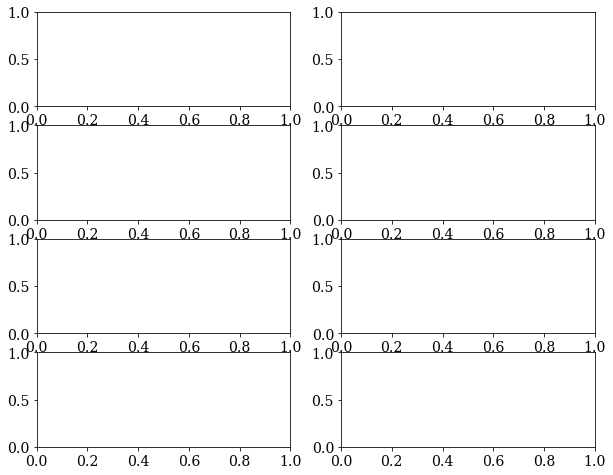

In [48]:
n = 5
fig, ax = plt.subplots((n - 1), 2, figsize=(10, 8))
for i, end_index in enumerate(np.arange(50000, 58000, 2000)):
    x = wind_resampled[end_index - 2000 : end_index]

    # Compute the structure function
    lags = np.arange(1, 0.2 * len(x))
    lag_times = lags * dt
    powers = [0.5, 2]

    good_output = sf.compute_sf(pd.DataFrame(x), lags, powers, retain_increments=True)

    good_output["ch_numerator"] = good_output["0.5_mean"] ** 4
    good_output["ch"] = good_output["ch_numerator"] / (
        0.457 + (0.494 / good_output["n"]) + (0.045 / good_output["n"] ** 2)
    )
    # Final part of original correction is so small as to be neglibile, hence why often left out
    # Down-weights outliers - recommended to use both
    good_output["dowd"] = (good_output["mapd"] ** 2) * 2.198

    lag_vals = get_lag_vals_list(good_output)

    ax[i, 0].plot(x)

    # ax.scatter(lag_vals["lag"], lag_vals["sq_diffs"], alpha=0.005, s=0.5, c="black")
    ax[i, 1].plot(lag_times, good_output["classical"], label="Classical", lw=3)
    # ax[i,1].plot(lag_times, good_output["ch"], label="Cressie-Hawkins", lw=1.5)
    # ax[i,1].plot(lag_times, good_output["dowd"], label="Dowd", lw=1.5)

    # lag_vals = sf.get_lag_vals_list(good_output)
    ax[i, 1].scatter(
        lag_vals["lag"] * dt,
        lag_vals["sq_diffs"],
        # 0.5 and 0.00001 works, 0.2 and 0.0001
        alpha=0.5,
        s=0.00001,
        c="black",
    )
    # plt.ylim(0, 300)
    ax[i, 1].semilogx()
    ax[i, 1].semilogy()
    ax[i, 1].set_ylim(
        good_output["classical"].min() / 3, good_output["classical"].max() * 10
    )  # log-space: *5
    ax[i, 1].legend(loc="upper left")
plt.show()

Mostly, we can just fit one time series of 8tc into each original one of about 2 hours. (8tc is approx 80min).

In [ ]:
for interval in good_inputs_list:
    print(len(interval))

4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000


## Get gapped statistics
Remove data from each input multiple times and compute SF, naive and interpolated: **currently handled by `get_gapped_sf.py` script**

---

## Analyse and plot results

In [ ]:
# Read in pickle file data/processed/list_of_list_of_dfs.pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.sf_funcs as sf
import pickle
import importlib

importlib.reload(sf)

with open("data/processed/sfs_psp_core_0.pkl", "rb") as f:
    list_of_list_of_dfs = pickle.load(f)

# Unpack the list of list of dfs
(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
) = list_of_list_of_dfs

In [ ]:
print(
    f"{len(all_interp_outputs_list[0])} versions of {len(all_interp_outputs_list)} outputs"
)

10 versions of 98 outputs


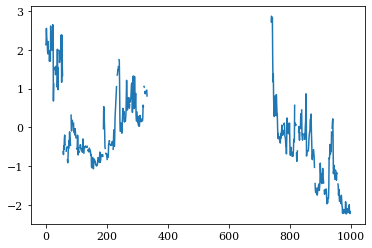

In [ ]:
plt.plot(all_bad_inputs_list[0][1])

In [ ]:
# Perform random train-test split
from sklearn.model_selection import train_test_split

(
    good_inputs_train,
    good_inputs_test,
    good_outputs_train,
    good_outputs_test,
    bad_inputs_train,
    bad_inputs_test,
    bad_outputs_train,
    bad_outputs_test,
    interp_inputs_train,
    interp_inputs_test,
    interp_outputs_train,
    interp_outputs_test,
) = train_test_split(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
    test_size=0.2,
    random_state=42,
)
print(
    f"Number of training interval: {len(good_inputs_train)} x {len(bad_inputs_train[0])} = {len(good_inputs_train)*len(bad_inputs_train[0])}"
)
print(
    f"Number of test intervals: {len(good_inputs_test)} x {len(bad_inputs_test[0])} = {len(good_inputs_test)*len(bad_inputs_test[0])}"
)

Number of training interval: 78 x 10 = 780
Number of test intervals: 20 x 10 = 200


### Naive

KeyError: 'sq_diffs'

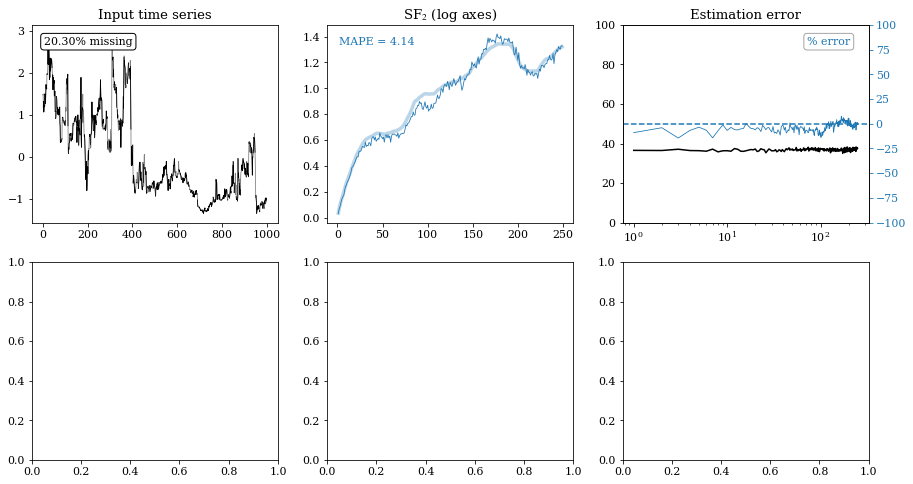

In [ ]:
# Check results, for a given clean input
importlib.reload(sf)

input_ind = 8
n_versions_to_plot = 2

sf.plot_sample(
    good_inputs_test,
    good_outputs_test,
    bad_inputs_test,
    bad_outputs_test,
    input_ind,
    n_versions_to_plot,
    False,
    estimator_list=["classical"],
)
# plt.savefig("plots_local/psp_missing_effect.png")

### Interpolated
NB: Error region for these results are taken from the SE for the naive calculations, reflecting the increased uncertainty of fewer *true* observations

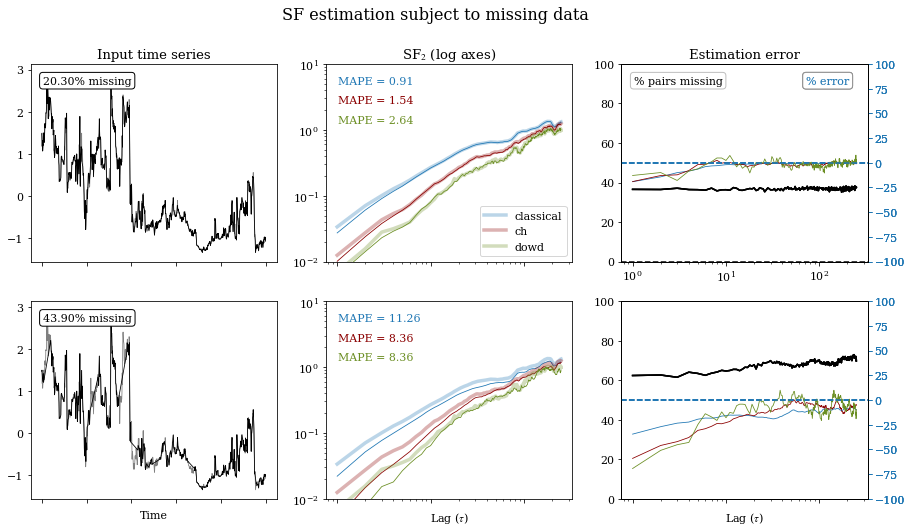

In [ ]:
importlib.reload(sf)
sf.plot_sample(
    good_inputs_test,
    good_outputs_test,
    interp_inputs_test,
    interp_outputs_test,
    input_ind,
    n_versions_to_plot,
    False,
    # "sosf",
)
# plt.savefig("plots/psp_missing_effect_lint.png")

## Do holistic analysis of errors

In [ ]:
# Concatenate the list of lists of dataframes to a single dataframe for error analysis
def concat_dfs(lst_of_list_of_dfs):
    merged_df = pd.concat(
        [pd.concat(lst, keys=range(len(lst))) for lst in lst_of_list_of_dfs],
        keys=range(len(lst_of_list_of_dfs)),
    )
    # Renaming MultiIndex levels
    merged_df.index.names = ["Original interval", "Interval version", "Lag"]
    return merged_df


bad_outputs_train_df = concat_dfs(bad_outputs_train)
interp_outputs_train_df = concat_dfs(interp_outputs_train)
bad_outputs_test_df = concat_dfs(bad_outputs_test)
interp_outputs_test_df = concat_dfs(interp_outputs_test)

In [ ]:
bad_outputs_train_df.columns

Index(['n', '0.5_mean', '0.5_std', '0.5_std_err', 'lag', 'classical', 'mapd',
       'classical_se', 'ch', 'dowd', 'missing_prop', 'classical_error',
       'classical_error_percent', 'ch_error', 'ch_error_percent', 'dowd_error',
       'dowd_error_percent', 'missing_prop_overall', 'lint'],
      dtype='object')

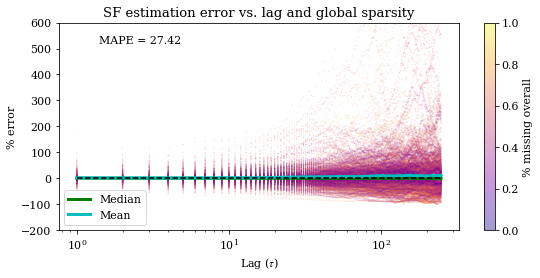

In [ ]:
importlib.reload(sf)
# View trends as fn of OVERALL missing amount
sf.plot_error_trend_line(bad_outputs_train_df, estimator="ch", y_axis_log=False)
# plt.savefig("plots/psp_missing_effect_holistic.png")

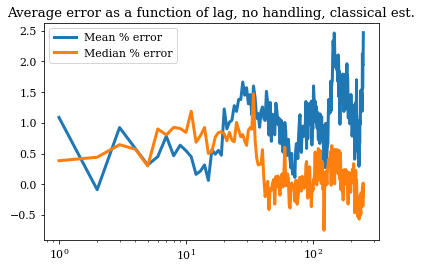

In [ ]:
def plot_average_errors(df):
    stats = df.groupby("Lag")["classical_error_percent"].describe()
    plt.plot(stats["mean"], lw=3, label="Mean % error")
    plt.plot(stats["50%"], lw=3, label="Median % error")
    plt.semilogx()
    plt.legend()
    plt.title("Average error as a function of lag, no handling, classical est.")


plot_average_errors(bad_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_avg.png")

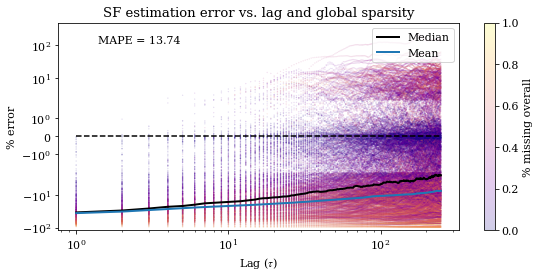

In [ ]:
sf.plot_error_trend_line(interp_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_lint.png")

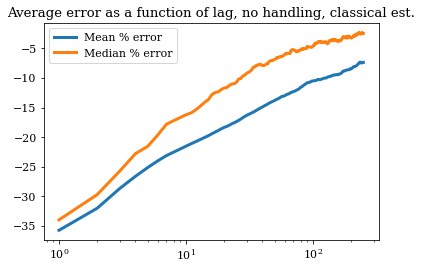

In [ ]:
plot_average_errors(interp_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_lint_avg.png")

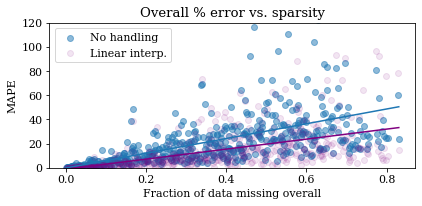

In [ ]:
sf.plot_error_trend_scatter(bad_outputs_train_df, interp_outputs_train_df)
# plt.savefig("plots/psp_missing_effect_holistic_scatter.png")

In [ ]:
# Investigating weird spikes at small lag
interp_outputs_train_df.sort_values("classical_error_percent", ascending=False).head(5)

n  0.5_mean   0.5_std  \
Original interval Interval version Lag                              
6                 9                180.0  820  0.947940  0.521198   
                                   179.0  821  0.949948  0.519389   
                                   178.0  822  0.948609  0.520864   
                                   181.0  819  0.946312  0.523404   
                                   177.0  823  0.950190  0.518619   

                                          0.5_std_err    lag  classical  \
Original interval Interval version Lag                                    
6                 9                180.0     0.018201  180.0   2.796374   
                                   179.0     0.018127  179.0   2.803267   
                                   178.0     0.018167  178.0   2.809589   
                                   181.0     0.018289  181.0   2.793558   
                                   177.0     0.018078  177.0   2.818391   

                                              mapd  classical_se        ch  \
Original interval Interval version Lag                                       
6                 9                180.0  0.729365      0.088795  1.764552   
                                   179.0  0.733334      0.126749  1.779559   
                                   178.0  0.728663      0.124517  1.769545   
                                   181.0  0.730150      0.102846  1.752460   
                                   177.0  0.726585      0.099062  1.781373   

                                              dowd  missing_prop  \
Original interval Interval version Lag                             
6                 9                180.0  1.169278      0.658537   
                                   179.0  1.182039      0.665043   
                                   178.0  1.167026      0.660584   
                                   181.0  1.171794      0.663004   
                                   177.0  1.160382      0.657351   

                                          classical_error  \
Original interval Interval version Lag                      
6                 9                180.0         1.865849   
                                   179.0         1.869058   
                                   178.0         1.870626   
                                   181.0         1.859484   
                                   177.0         1.874198   

                                          classical_error_percent  ch_error  \
Original interval Interval version Lag                                        
6                 9                180.0               200.515710  1.064256   
                                   179.0               200.068650  1.059948   
                                   178.0               199.222464  1.060972   
                                   181.0               199.072432  1.052572   
                                   177.0               198.497446  1.075260   

                                          ch_error_percent  dowd_error  \
Original interval Interval version Lag                                   
6                 9                180.0        151.972133    0.555071   
                                   179.0        147.294781    0.576580   
                                   178.0        149.733692    0.552385   
                                   181.0        150.391633    0.572809   
                                   177.0        152.278688    0.563471   

                                          dowd_error_percent  \
Original interval Interval version Lag                         
6                 9                180.0           90.371908   
                                   179.0           95.230235   
                                   178.0           89.871012   
                                   181.0           95.629874   
                                   177.0           94.397965   

                                          missing_prop_overa

## Create empirical correction factor

Here we work with the interpolated output errors, as they are more consistent that the no-handling errors (as evident in the error vs. lag and global sparsity plot), and with the *local* sparsity, as this gives us more information than the global sparsity.

In [ ]:
missing_measure = "missing_prop"
n_bins = 15

In [ ]:
heatmap_bin_vals, heatmap_bin_edges, lookup_table = sf.create_heatmap_lookup(
    interp_outputs_train_df, missing_measure, n_bins, log=True
)

# If wanting linear bins, can then simply use the following:

# axs = sf.plot_heatmap(
#     heatmap_bin_vals,
#     heatmap_bin_edges,
#     "Missing proportion",
#     False,
# )

fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(
    heatmap_bin_edges[0],
    heatmap_bin_edges[1],
    heatmap_bin_vals.T,
    cmap="bwr",
)
plt.colorbar(label="MPE")
plt.clim(-100, 100)
plt.xlabel("Lag")
plt.ylabel("Missing proportion")
plt.title("Distribution of missing proportion and lag")
ax.set_facecolor("black")
ax.set_xscale("log")
# plt.savefig(f"plots/psp_correction_heatmap_{n_bins}_bins.png")

KeyboardInterrupt: 

Check out sample size in each bin (above just shows where there is no data with black bins).
Below 2D histogram is not working for log bins, for some reason

Text(0.5, 1.0, 'Distribution of missing proportion and lag')

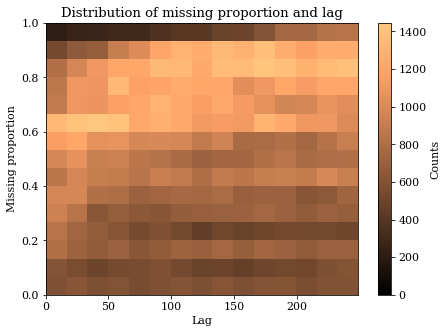

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
hb = ax.hist2d(
    interp_outputs_train_df["lag"],
    interp_outputs_train_df[missing_measure],
    bins=n_bins,
    cmap="copper",
    range=[[0, interp_outputs_train_df.lag.max()], [0, 1]],
)
plt.colorbar(hb[3], ax=ax, label="Counts")
hb[3].set_clim(0, hb[0].max())
plt.xlabel("Lag")
plt.ylabel("Missing proportion")
plt.title("Distribution of missing proportion and lag")
# plt.savefig("plots/psp_heatmap_sample_size.png")

In [ ]:
# Compute heatmap of average error as fn of lag and missing prop at that lag
heatmap_bin_vals_3d, heatmap_bin_edges_3d, lookup_table_3d = (
    sf.create_heatmap_lookup_3D(interp_outputs_train_df, missing_measure, n_bins, True)
)

## Apply empirical correction factor to bad SFs

*Regardless of whether I save to it again, `interp_outputs_test_df` is edited within the function each time, which is fine by me.*

In [ ]:
def compute_scaling_new(bad_output, var, heatmap_vals):
    """
    Extracting values from each bin to create a look-up table. Note that due to binning we have to find the nearest value to get the corresponding MAPE for a given lag and proportion of pairs remaining. Using MPE as we want to maintaing the direction of the error for compensating."""
    df = heatmap_vals.copy()

    # Precompute scaling factors
    df["scaling"] = 1 / (1 + df["MPE"] / 100)
    df["scaling_lower"] = 1 / (1 + (df["MPE"] + 2 * df["MPE_std_err"]) / 100)
    df["scaling_upper"] = 1 / (1 + (df["MPE"] - 2 * df["MPE_std_err"]) / 100)

    # If no nearest bin is found (len(nearest_row)=0), scaling will be 1 (the same)
    bad_output["scaling"] = 1
    bad_output["scaling_lower"] = 1
    bad_output["scaling_upper"] = 1

    for i, row in bad_output.iterrows():
        desired_prop = row[var]
        desired_lag = i[2]  # 3rd level of multi-index = lag

        # Compute absolute differences
        lag_diff = np.abs(df["Lag"] - desired_lag)
        prop_diff = np.abs(df[var] - desired_prop)

        # Find the nearest row
        min_lag_diff = lag_diff.min()
        min_prop_diff = prop_diff.min()
        nearest_row = df.loc[(lag_diff == min_lag_diff) & (prop_diff == min_prop_diff)]

        if len(nearest_row) > 1:
            result = nearest_row.head(1)
        else:
            result = nearest_row.head(1)
            scaling = result["scaling"].values[0]
            scaling_lower = result["scaling_lower"].values[0]
            scaling_upper = result["scaling_upper"].values[0]

        bad_output.at[i, "scaling"] = scaling
        bad_output.at[i, "scaling_lower"] = scaling_lower
        bad_output.at[i, "scaling_upper"] = scaling_upper

    bad_output.loc[bad_output["classical_error"] == 0, "scaling"] = (
        1  # Catching 0 errors
    )

    bad_output["classical_corrected"] = bad_output["classical"] * bad_output["scaling"]
    bad_output["classical_corrected_lower"] = (
        bad_output["classical"] * bad_output["scaling_lower"]
    )
    bad_output["classical_corrected_upper"] = (
        bad_output["classical"] * bad_output["scaling_upper"]
    )
    print("finished correction, now smoothing")
    # Smoothing potentially jumpy correction
    # bad_output["scaling_smoothed"] = (
    #     bad_output["scaling"].rolling(window=20, min_periods=1).mean()
    # )
    # bad_output["classical_corrected_smoothed"] = (
    #     bad_output["classical"] * bad_output["scaling_smoothed"]
    # )
    print("finished smoothing, now next interval")
    return bad_output

In [ ]:
interp_outputs_test_df = sf.compute_scaling(
    interp_outputs_test_df, missing_measure, lookup_table
)

In [ ]:
interp_outputs_test_df = sf.compute_scaling_3d(
    interp_outputs_test_df, missing_measure, lookup_table_3d
)

In [ ]:
interp_outputs_test_df.columns

Index(['n', '0.5_mean', '0.5_std', '0.5_std_err', 'lag', 'classical', 'mapd',
       'classical_se', 'ch', 'dowd', 'missing_prop', 'classical_error',
       'classical_error_percent', 'ch_error', 'ch_error_percent', 'dowd_error',
       'dowd_error_percent', 'missing_prop_overall', 'lint', 'scaling',
       'scaling_lower', 'scaling_upper', 'classical_corrected',
       'classical_corrected_lower', 'classical_corrected_upper',
       'scaling_smoothed', 'classical_corrected_smoothed',
       'classical_corrected_3d'],
      dtype='object')

In [ ]:
print(
    "Mean MAPE of interpolated intervals in test set = {:.2f}".format(
        interp_outputs_test_df["classical_error_percent"].abs().mean()
    )
)

# Calculate corrected test set error
error_percents_2d = []
error_percents_3d = []
times_to_gap = 2

for i, df in enumerate(good_outputs_test):
    for j in range(times_to_gap):
        # Calculate difference
        error_2d = (
            interp_outputs_test_df.loc[(i, j), "classical_corrected"] - df["classical"]
        )
        error_percent_2d = error_2d / df["classical"] * 100
        error_percents_2d.append(error_percent_2d)

        error_3d = (
            interp_outputs_test_df.loc[(i, j), "classical_corrected_3d"]
            - df["classical"]
        )
        error_percent_3d = error_3d / df["classical"] * 100
        error_percents_3d.append(error_percent_3d)

print(
    "Mean MAPE of corrected (2D) interpolated intervals test set = {:.2f}".format(
        np.mean(np.abs(error_percents_2d))
    )
)
print(
    "Mean MAPE of corrected (3D) interpolated intervals test set = {:.2f}".format(
        np.mean(np.abs(error_percents_3d))
    )
)

Mean MAPE of interpolated intervals in test set = 11.30
Mean MAPE of corrected (2D) interpolated intervals test set = 11.45
Mean MAPE of corrected (3D) interpolated intervals test set = 14.62


In [ ]:
interp_outputs_test_df.loc[0, 1]["classical_error_percent"].abs().mean()

0.7777204112238583

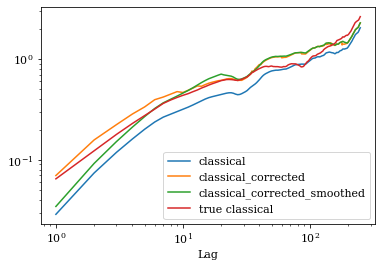

In [ ]:
interp_outputs_test_df.loc[0, 1][
    [
        "classical",
        "classical_corrected",
        # "classical_corrected_3d",
        "classical_corrected_smoothed",
    ]
].plot()
good_outputs_test[0]["classical"].plot(label="true classical")
plt.semilogx()
plt.semilogy()
plt.legend()
plt.show()

## Using the test set, plot the same intervals originally plotted

In [ ]:
versions_ordered_sparsity = (
    interp_outputs_test_df.loc[input_ind, : n_versions_to_plot - 1, :]
    .sort_values("missing_prop_overall")
    .index.get_level_values(1)
    .unique()
    .values
)
# Extract the unique second-level indexes
for i in versions_ordered_sparsity:
    print(i)

1
0


Text(0.5, 0.98, 'Applying correction factor to interpolated SFs in test set')

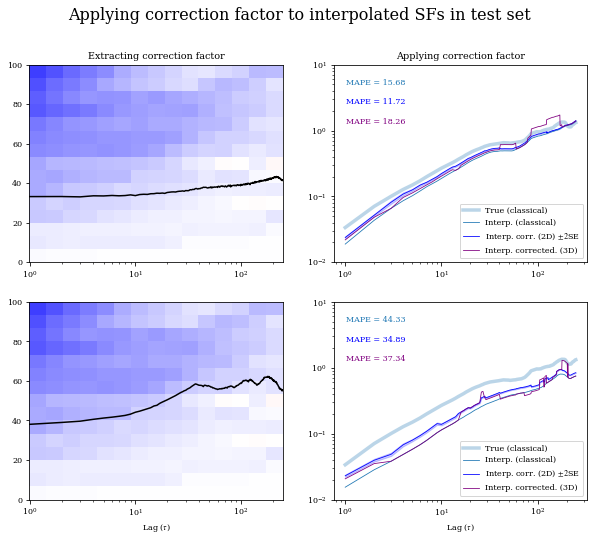

In [ ]:
fig, axs = plt.subplots(n_versions_to_plot, 2, figsize=(10, 4 * n_versions_to_plot))

# Get the relevent indices in order of sparsity for better plot aesthetics
versions_ordered_sparsity = (
    interp_outputs_test_df.loc[input_ind, : n_versions_to_plot - 1, :]
    .sort_values("missing_prop_overall")
    .index.get_level_values(1)
    .unique()
    .values
)

for i, int_version in enumerate(versions_ordered_sparsity):
    mape_bad = (
        interp_outputs_test_df.loc[input_ind, int_version]["classical_error_percent"]
        .abs()
        .mean()
    )
    mape_corrected = (
        error_percents_2d[input_ind * times_to_gap + int_version].abs().mean()
    )
    mape_corrected_3d = (
        error_percents_3d[input_ind * times_to_gap + int_version].abs().mean()
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_bad),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.9),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="C0",
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round"),
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_corrected),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.8),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="blue",
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round"),
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_corrected_3d),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.7),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="purple",
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round"),
    )

    axs[i, 1].plot(
        good_outputs_test[input_ind]["classical"],
        color="C0",
        label="True (classical)",
        lw=3.5,
        alpha=0.3,
    )
    axs[i, 1].plot(
        interp_outputs_test_df.loc[input_ind, int_version]["classical"],
        color="C0",
        lw=0.8,
        label="Interp. (classical)",
    )
    # axs[i, 1].plot(
    #     sf_corrected["classical"] * sf_corrected["scaling"], c="blue", label="Corrected Bad"
    # )
    axs[i, 1].plot(
        interp_outputs_test_df.loc[input_ind, int_version]["classical_corrected"],
        c="blue",
        lw=0.8,
        label="Interp. corr. (2D) $\pm 2$SE",
    )
    axs[i, 1].fill_between(
        interp_outputs_test_df.loc[input_ind, int_version]["lag"],
        interp_outputs_test_df.loc[input_ind, int_version]["classical_corrected_lower"],
        interp_outputs_test_df.loc[input_ind, int_version]["classical_corrected_upper"],
        color="blue",
        alpha=0.2,
    )
    #    axs[i, 1].plot(
    #        sf_corrected["classical_corrected_smoothed"],
    #        c="orange",
    #        label="Corrected Bad Smoothed",
    #    )
    axs[i, 1].plot(
        interp_outputs_test_df.loc[input_ind, int_version]["classical_corrected_3d"],
        c="purple",
        lw=0.8,
        label="Interp. corrected. (3D)",
    )
    axs[i, 1].semilogx()
    axs[i, 1].semilogy()
    axs[i, 1].set_ylim(1e-2, 1e1)
    axs[i, 1].legend(loc="lower right")

    # if log is True:
    c = axs[i, 0].pcolormesh(
        heatmap_bin_edges[0],
        heatmap_bin_edges[1] * 100,  # convert to % Missing
        heatmap_bin_vals.T,
        cmap="bwr",
    )
    # fig.colorbar(c, ax=axs[i, 0], label="MPE")
    c.set_clim(-100, 100)
    c.set_facecolor("black")
    # axs[i, 0].set_xlabel("Lag")
    axs[i, 0].plot(
        interp_outputs_test_df.loc[input_ind, int_version]["lag"],
        interp_outputs_test_df.loc[input_ind, int_version][missing_measure] * 100,
        c="black",
    )

    axs[i, 0].set_xscale("log")
    axs[i, 0].set_ylim(0, 100)
    # axs[i, 0] = sf.plot_heatmap(
    #     heatmap_bin_vals_log,
    #     heatmap_bin_edges_log,
    #     missing_measure=missing_measure,
    #     log=True,
    #     overlay_x=df_to_plot["lag"],
    #     overlay_y=df_to_plot[missing_measure],
    #     subplot=axs[i, 0],
    # )
axs[0, 1].set_title("Applying correction factor")
axs[0, 0].set_title("Extracting correction factor")
axs[n_versions_to_plot - 1, 0].set_xlabel("Lag ($\\tau$)")
axs[n_versions_to_plot - 1, 1].set_xlabel("Lag ($\\tau$)")
fig.suptitle("Applying correction factor to interpolated SFs in test set", size=16)

## Plotting the 3D heatmap

In [ ]:
plt.rcParams.update({"font.size": 8})

Text(0, 0.5, 'Missing proportion')

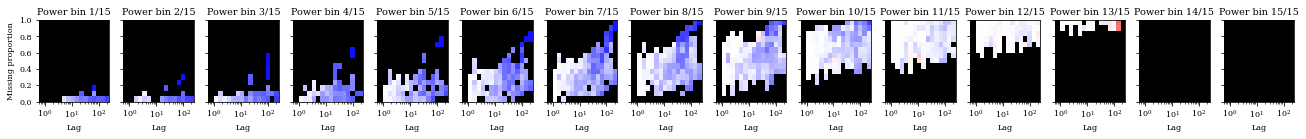

In [ ]:
fig, ax = plt.subplots(1, n_bins, figsize=(1.5 * n_bins, 1.5))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[1],
        heatmap_bin_vals_3d[:, :, i],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Lag")
    ax[i].set_xlim(6e-1, 250)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].set_title(
        f"Power bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
ax[0].set_ylabel("Missing proportion")
# plt.savefig("psp_heatmap_3d_power.png")

Text(0, 0.5, 'Power')

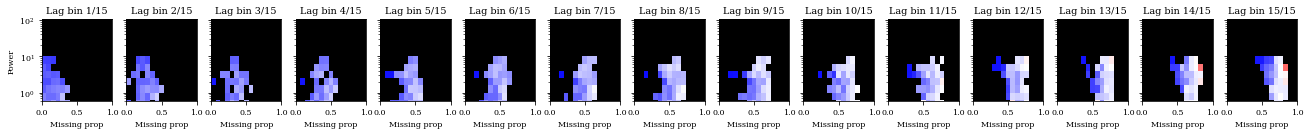

In [ ]:
fig, ax = plt.subplots(1, n_bins, figsize=(1.5 * n_bins, 1.5))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[1],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[i, :, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Missing prop")
    # ax[i].set_xlim(6e-1, 250)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogy()
    ax[i].set_ylim(6e-1, 105)
    ax[i].set_title(
        f"Lag bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Missing prop")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
ax[0].set_ylabel("Power")
# plt.savefig("psp_heatmap_3d_lag.png")

Text(0, 0.5, 'Power')

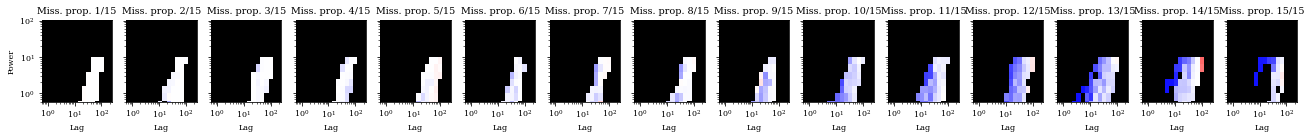

In [ ]:
fig, ax = plt.subplots(1, n_bins, figsize=(1.5 * n_bins, 1.5))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[:, i, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    ax[i].set_xlim(6e-1, 250)
    ax[i].set_ylim(6e-1, 105)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].semilogy()
    ax[i].set_title(
        f"Miss. prop. {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
ax[0].set_ylabel("Power")
# plt.savefig("psp_heatmap_3d_missing.png")